# This script aims at developing the build_shapes script on the basis of PyPSA-Eur

In [2]:
# import
import os
import sys

# IMPORTANT: RUN SCRIPT FROM THIS SCRIPTS DIRECTORY i.e data_exploration/ TODO: make more robust
# os.chdir(os.path.dirname(os.path.abspath(__file__)))
sys.path.append("./../../scripts")

import logging
import shutil

import geopandas as gpd
import geoplot as gplt
import fiona

import numpy as np
import pandas as pd
import requests
import zipfile
import matplotlib.pyplot as plt
from esy.osmfilter import run_filter
from esy.osmfilter import Node, Relation, Way
from esy.osmfilter import osm_info as osm_info
from esy.osmfilter import osm_pickle as osm_pickle

# from iso_country_codes import AFRICA_CC
# from ..scripts.iso_country_codes import AFRICA_CC

from shapely.geometry import LineString, Point, Polygon

logger = logging.getLogger(__name__)

ModuleNotFoundError: No module named 'geoplot'

In [ ]:
from _helpers import (
    configure_logging,
    sets_path_to_root,
    two_2_three_digits_country,
    three_2_two_digits_country,
)

three_2_two_digits_country("AFG")

In [ ]:
test_CC = {"ZAF": "SOUTH AFRICA", "NGA": "Nigeria"}  # or any other country
update = True


def download_GADM(country_code, update=False):
    """
    Download gpkg file from GADM for a given country code

    Parameters
    ----------
    country_code : str
        Three letter country codes of the downloaded files
    update : bool
        Name of the network component
        Update = true, forces re-download of files

    Returns
    -------
    gpkg file per country

    """

    GADM_filename = f"gadm36_{country_code}"
    GADM_url = f"https://biogeo.ucdavis.edu/data/gadm3.6/gpkg/{GADM_filename}_gpkg.zip"

    GADM_inputfile_zip = os.path.join(
        os.getcwd(), "data", "gadm", GADM_filename, GADM_filename + ".zip"
    )  # Input filepath zip

    GADM_inputfile_gpkg = os.path.join(
        os.getcwd(), "data", "gadm", GADM_filename, GADM_filename + ".gpkg"
    )  # Input filepath gpkg

    if not os.path.exists(GADM_inputfile_zip) or update is True:
        print(f"{GADM_filename} does not exist, downloading to {GADM_inputfile_zip}")
        #  create data/osm directory
        os.makedirs(os.path.dirname(GADM_inputfile_zip), exist_ok=True)

        with requests.get(GADM_url, stream=True) as r:
            with open(GADM_inputfile_zip, "wb") as f:
                shutil.copyfileobj(r.raw, f)

        with zipfile.ZipFile(GADM_inputfile_zip, "r") as zip_ref:
            zip_ref.extractall(os.path.dirname(GADM_inputfile_zip))

    return GADM_inputfile_gpkg, GADM_filename


# download GADM gpkg files of selected countries
for country_code in test_CC.keys():
    # download file gpkgS
    file_gpkg, _ = download_GADM(country_code, False)
    print(file_gpkg)

print("Completed")

In [ ]:
# download gpkg files of selected countries and append them to a single GeoDataFrame for each desired layer

layers = [0, 2]

# initialize dictionary for all geodataframe by layer
geodf_all = {layer: gpd.GeoDataFrame() for layer in layers}


def get_GADM_layer(country_list, layer, update=False):
    # initialization of the geoDataFrame
    geodf_GADM = gpd.GeoDataFrame()

    for country_code in country_list:
        # download file gpkg
        file_gpkg, name_file = download_GADM(country_code, False)

        # get layers of a geopackage
        list_layers = fiona.listlayers(file_gpkg)

        # read gpkg file
        geodf_temp = gpd.read_file(
            file_gpkg, layer=list_layers[list_layers[layer]]
        )  # name_file+"_"+str(layer))

        # append geodataframes
        geodf_GADM = geodf_GADM.append(geodf_temp)

    geodf_GADM.reset_index(drop=True, inplace=True)

    return geodf_GADM


geodf_GADM_countries = get_GADM_layer(
    test_CC.keys(), 0, update=False
)  # layer 0 is country shapes
geodf_GADM_NUTS3 = get_GADM_layer(
    test_CC.keys(), 2, update=False
)  # layer 2 are the most fine shapes available (to be checked if always available)

In [ ]:
geodf_GADM_countries

In [ ]:
geodf_GADM_NUTS3.plot()

In [ ]:
# # download file gpkg
# file_gpkg = download_gpkg(list(test_CC.keys())[0], False)

# print(fiona.listlayers(file_gpkg))

# # read gpkg file
# geodf_temp = gpd.read_file(file_gpkg, layer="gadm36_ZAF_0")
# geodf_temp.plot()

In [ ]:
import pandas as pd

df = pd.DataFrame()

df["ciao"] = list(range(0, 15))
df["ciao"] = [10 - c for c in df["ciao"]]
df["ciao"]

In [ ]:
import fiona

EEZ_gpkg = os.path.join(
    os.getcwd(), "data", "raw", "eez", "eez_v11.gpkg"
)  # Input filepath gpkg

geodf_EEZ = gpd.read_file(EEZ_gpkg)

fiona.listlayers(EEZ_gpkg)

In [ ]:
selected_countries_codes = ["AF"]

In [ ]:
three_2_two_digits_country("None")

In [ ]:
import numpy as np

np.nan in ["AF"]

In [ ]:
print(geodf_EEZ.loc[18, "ISO_TER1"])

In [ ]:
geodf_EEZ

In [ ]:
a = geodf_EEZ.dropna(axis=0, how="any", subset=["ISO_TER1"]).reset_index().copy()
a["ISO_TER1"][17]

In [ ]:
[print(three_2_two_digits_country(x)) for x in geodf_EEZ["ISO_TER1"]]

In [ ]:
geodf_EEZ.ISO_TER1.unique()

In [ ]:
test_CC = {"AFG": "d"}  # or any other country
update = False


def load_EEZ(selected_countries_codes, name_file="eez_v11.gpkg"):
    EEZ_gpkg = os.path.join(
        os.getcwd(), "data", "raw", "eez", name_file
    )  # Input filepath gpkg

    if not os.path.exists(EEZ_gpkg):
        raise Exception(
            f"File EEZ {name_file} not found, please download it from https://www.marineregions.org/download_file.php?name=World_EEZ_v11_20191118_gpkg.zip and copy it in {os.path.dirname(EEZ_gpkg)}"
        )

    geodf_EEZ = gpd.read_file(EEZ_gpkg)
    geodf_EEZ = geodf_EEZ[
        ["ISO_TER1", "geometry"]
    ]  # [["ISO_TER1", "TERRITORY1", "ISO_SOV1", "ISO_SOV2", "ISO_SOV3", "geometry"]]
    geodf_EEZ = geodf_EEZ[
        [any([x in selected_countries_codes]) for x in geodf_EEZ["ISO_TER1"]]
    ]
    geodf_EEZ.reset_index(drop=True, inplace=True)

    geodf_EEZ.rename(columns={"ISO_TER1": "name"}, inplace=True)

    return geodf_EEZ


geodf_EEZ = load_EEZ(test_CC.keys())

# print(geodf_EEZ.keys())
geodf_EEZ.head()

In [ ]:
file_country_shapes_clean = os.path.join(
    os.getcwd(), "data", "clean", "eez", "country_shapes" + ".geojson"
)
file_off_shore_shapes_clean = os.path.join(
    os.getcwd(), "data", "clean", "eez", "off_shore_shapes" + ".geojson"
)
os.makedirs(os.path.dirname(file_country_shapes_clean), exist_ok=True)

# country shapes
geodf_country = geodf_GADM_countries[["GID_0", "geometry"]].copy()
geodf_country.rename(columns={"GID_0": "name"}, inplace=True)

geodf_country.to_file(file_country_shapes_clean, driver="GeoJSON")  # Generate GeoJson
geodf_EEZ.to_file(file_off_shore_shapes_clean, driver="GeoJSON")  # Generate GeoJson

In [ ]:
import pycountry as pyc


def get_country(target, **keys):
    """
    Function to convert country codes using pycountry

    Parameters
    ----------
    target: str
        Desired type of country code.
        Examples:
            - 'alpha_3' for 3-digit
            - 'alpha_2' for 2-digit
            - 'name' for full country name

    keys: dict
        Specification of the country name and reference system.
        Examples:
            - alpha_3="ZAF" for 3-digit
            - alpha_2="ZA" for 2-digit
            - name="South Africa" for full country name

    Returns
    -------
    country code as requested in keys or np.nan, when country code is not recognized

    Example of usage
    -------
    - Convert 2-digit code to 3-digit codes: get_country('alpha_3', alpha_2="ZA")
    - Convert 3-digit code to 2-digit codes: get_country('alpha_2', alpha_3="ZAF")
    - Convert 2-digit code to full name: get_country('name', alpha_2="ZA")

    """

    assert len(keys) == 1
    try:
        return getattr(pyc.countries.get(**keys), target)
    except (KeyError, AttributeError):
        return np.nan


def two_2_three_digits_country(two_code_country):
    """
    Convert 2-digit to 3-digit country code:

    Parameters
    ----------
    two_code_country: str
        2-digit country name

    Returns
    ----------
    three_code_country: str
        3-digit country name
    """
    three_code_country = get_country("alpha_3", alpha_2=two_code_country)
    return three_code_country


def three_2_two_digits_country(three_code_country):
    """
    Convert 3-digit to 2-digit country code:

    Parameters
    ----------
    three_code_country: str
        3-digit country name

    Returns
    ----------
    two_code_country: str
        2-digit country name
    """
    two_code_country = get_country("alpha_2", alpha_3=three_code_country)
    return two_code_country


def two_digits_2_name_country(two_code_country):
    """
    Convert 2-digit country code to full name country:

    Parameters
    ----------
    two_code_country: str
        2-digit country name

    Returns
    ----------
    full_name: str
        full country name
    """
    full_name = get_country("name", alpha_2=two_code_country)
    return full_name


print(two_2_three_digits_country("ZA"))
print(three_2_two_digits_country("ZAF"))
print(two_digits_2_name_country("ZA"))

In [ ]:
two_2_three_digits_country("ZA").upper()

In [ ]:
def download_WorldPop(country_code, year=2020, update=False, out_logging=True):
    """
    Download tiff file for each country code

    Parameters
    ----------
    country_code : str
        Two letter country codes of the downloaded files.
        Files downloaded from https://data.worldpop.org/ datasets WorldPop UN adjusted
    update : bool
        Update = true, forces re-download of files

    Returns
    -------
    gpkg file per country

    """

    # UN not adjusted
    # WorldPop_filename = f"{two_2_three_digits_country(country_code).lower()}_ppp_{year}_constrained.tif"
    # WorldPop_url = f"https://data.worldpop.org/GIS/Population/Global_2000_2020_Constrained/2020/BSGM/{two_2_three_digits_country(country_code).upper()}/{WorldPop_filename}"

    WorldPop_filename = f"{two_2_three_digits_country(country_code).lower()}_ppp_{year}_UNadj_constrained.tif"
    WorldPop_url = f"https://data.worldpop.org/GIS/Population/Global_2000_2020_Constrained/2020/BSGM/{two_2_three_digits_country(country_code).upper()}/{WorldPop_filename}"

    WorldPop_inputfile = os.path.join(
        os.path.dirname(os.getcwd()), "data", "raw", "WorldPop", WorldPop_filename
    )  # Input filepath zip

    if not os.path.exists(WorldPop_inputfile) or update is True:
        if out_logging:
            print(
                f"{WorldPop_filename} does not exist, downloading to {WorldPop_inputfile}"
            )
        #  create data/osm directory
        os.makedirs(os.path.dirname(WorldPop_inputfile), exist_ok=True)

        with requests.get(WorldPop_url, stream=True) as r:
            with open(WorldPop_inputfile, "wb") as f:
                shutil.copyfileobj(r.raw, f)

    return WorldPop_inputfile, WorldPop_filename


download_WorldPop("AF")

In [ ]:
def download_GADM(country_code, update=False):
    """
    Download gpkg file from GADM for a given country code

    Parameters
    ----------
    country_code : str
        Two letter country codes of the downloaded files
    update : bool
        Update = true, forces re-download of files

    Returns
    -------
    gpkg file per country

    """

    GADM_filename = f"gadm36_{two_2_three_digits_country(country_code)}"
    GADM_url = f"https://biogeo.ucdavis.edu/data/gadm3.6/gpkg/{GADM_filename}_gpkg.zip"

    GADM_inputfile_zip = os.path.join(
        os.path.dirname(os.getcwd()),
        "data",
        "raw",
        "gadm",
        GADM_filename,
        GADM_filename + ".zip",
    )  # Input filepath zip

    GADM_inputfile_gpkg = os.path.join(
        os.path.dirname(os.getcwd()),
        "data",
        "raw",
        "gadm",
        GADM_filename,
        GADM_filename + ".gpkg",
    )  # Input filepath gpkg

    if not os.path.exists(GADM_inputfile_gpkg) or update is True:
        print(f"{GADM_filename} does not exist, downloading to {GADM_inputfile_zip}")
        #  create data/osm directory
        os.makedirs(os.path.dirname(GADM_inputfile_zip), exist_ok=True)

        with requests.get(GADM_url, stream=True) as r:
            with open(GADM_inputfile_zip, "wb") as f:
                shutil.copyfileobj(r.raw, f)

        with zipfile.ZipFile(GADM_inputfile_zip, "r") as zip_ref:
            zip_ref.extractall(os.path.dirname(GADM_inputfile_zip))

    return GADM_inputfile_gpkg, GADM_filename


def get_GADM_layer(country_list, layer_id, update=False):
    """
    Function to retrive a specific layer id of a geopackage for a selection of countries
    """

    # initialization of the geoDataFrame
    geodf_GADM = gpd.GeoDataFrame()

    for country_code in country_list:
        # download file gpkg
        file_gpkg, name_file = download_GADM(country_code, False)

        # get layers of a geopackage
        list_layers = fiona.listlayers(file_gpkg)

        # read gpkg file
        geodf_temp = gpd.read_file(file_gpkg, layer=list_layers[layer_id])

        # convert country name representation of the main country (GID_0 column)
        geodf_temp["GID_0"] = [
            three_2_two_digits_country(twoD_c) for twoD_c in geodf_temp["GID_0"]
        ]

        # append geodataframes
        geodf_GADM = geodf_GADM.append(geodf_temp)

    geodf_GADM.reset_index(drop=True, inplace=True)

    return geodf_GADM

In [ ]:
import fiona
import rasterio


def add_population_data_nuts3(df_nuts3, country_codes, year=2020):
    """Function to add the population info for each country shape in the dataset"""

    # initialize new population column
    df_nuts3["pop"] = 0

    for c_code in country_codes:
        WorldPop_inputfile, WorldPop_filename = download_WorldPop(
            country_code, year, update=False, out_logging=False
        )

        with rasterio.open("tests/data/RGB.byte.tif") as src:
            geoms = df_nuts3.loc[df_nuts3["country"] == c_code, "geometry"]

            out_image, out_transform = rasterio.mask.mask(src, geoms, crop=True)
            out_meta = src.meta

        ret = rasterio.features.geometry_mask()

In [ ]:
import fiona
import rasterio
from rasterio.mask import mask

update = False
countries = ["AF"]
country_codes = ["AF"]

# download data if needed and get the last layer id [-1], corresponding to the highest resolution
df_nuts3 = get_GADM_layer(countries, -1, update)

# select and rename columns
# df_eez = df_eez[["GID_0", "geometry"]].copy()
df_nuts3.rename(columns={"GID_0": "country"}, inplace=True)
df_nuts3["pop"] = 0
print(sum(df_nuts3["pop"]))


def add_population_data_nuts3(df_nuts3, country_codes, year=2020):
    """Function to add the population info for each country shape in the dataset"""
    # initialize new population column
    df_nuts3["pop"] = 0

    for c_code in country_codes:
        WorldPop_inputfile, WorldPop_filename = download_WorldPop(
            c_code, 2020, update=False, out_logging=False
        )

        with rasterio.open(WorldPop_inputfile) as src:
            print(src)
            country_rows = df_nuts3.loc[df_nuts3["country"] == c_code]

            for index, row in country_rows.iterrows():
                # select the desired area of the raster corresponding to each polygon
                out_image, out_transform = mask(
                    src, row["geometry"], all_touched=True, invert=False, nodata=0.0
                )

                # print(out_image)

                # calculate total population in the selected geometry
                pop_by_geom = sum(sum(out_image[0]))

                print(index, " out of ", country_rows.shape[0])
                # print(pop_by_geom)

                # update the population data in the dataset
                df_nuts3.loc[index, "pop"] = pop_by_geom
                # print(country_rows.loc[index, "pop"])

                # df_nuts3.loc[df_nuts3["country"] == c_code]["pop"] = pop_by_geom

                # out_meta = src.meta
                # print(src.meta)
                # print(out_transform)
                # print(out_image)
                # out_pop = map(out_image, lambda x: sum(sum(x)))
                # out_pixels = map(out_image, lambda x: sum(sum(x > 0.001)))
                # print(out_pop)
                # print(out_pixels)
                # with rasterio.open("masked2.tif", "w", **out_meta) as dest:
                #     dest.write(out_image)


add_population_data_nuts3(df_nuts3, ["AF"])

In [ ]:
df_nuts3.iloc[[0, 1]].copy()

In [ ]:
a = np.ones((2, 3))
a

ut_pop = [sum(sum(x)) for x in [a]]
ut_pop

In [ ]:
ax = gplt.polyplot(df_nuts3["geometry"], figsize=(7, 8))
# gplt.polyplot(df_nuts3.iloc[[0,1]].copy(), ax=ax)

In [ ]:
df_nuts3.loc[df_nuts3["country"] == "AF", "geometry"][0]

In [ ]:
import xarray as xr


def convert_GDPPPP_nc2tif(name_file_nc, year=2015, out_logging=False):
    """
    Function to convert the nc database of the GDP to tif, based on the work at https://doi.org/10.1038/sdata.2018.4.
    The dataset shall be downloaded independently by the user (see guide) or toghether with pypsa-africa package.
    """

    if out_logging:
        print("Access to GDP raster data")

    # tif namefile
    name_file_tif = name_file_nc[:-2] + "tif"
    print(name_file_tif)

    # path of the nc file
    GDP_nc = os.path.join(
        os.path.dirname(os.getcwd()), "data", "raw", "GDP", name_file_nc
    )  # Input filepath nc

    # path of the tif file
    GDP_tif = os.path.join(
        os.path.dirname(os.getcwd()), "data", "raw", "GDP", name_file_tif
    )  # Input filepath nc

    # Check if file exists, otherwise throw exception
    if not os.path.exists(GDP_nc):
        raise Exception(
            f"File EEZ {name_file_nc} not found, please download it from https://datadryad.org/stash/dataset/doi:10.5061/dryad.dk1j0 and copy it in {os.path.dirname(GDP_nc)}"
        )

    # open nc dataset
    GDP_dataset = xr.open_dataset(GDP_nc)

    # get the requested year of data or its closest one
    list_years = GDP_dataset["time"]
    if not year in list_years:
        if out_logging:
            print(
                f"GDP data of year {year} not found, selected the most recent data ({int(list_years[-1])})"
            )
        year = float(list_years[-1])

    # subset of the database and conversion to dataframe
    GDP_dataset = GDP_dataset.sel(time=year).drop("time")
    GDP_dataset.rio.to_raster(GDP_tif)

    return GDP_tif, name_file_tif


def load_GDP(
    countries_codes,
    year=2015,
    update=False,
    out_logging=False,
    name_file_nc="GDP_PPP_1990_2015_5arcmin_v2.nc",
):
    """
    Function to load the database of the GDP, based on the work at https://doi.org/10.1038/sdata.2018.4.
    The dataset shall be downloaded independently by the user (see guide) or toghether with pypsa-africa package.
    """

    if out_logging:
        print("Access to GDP raster data")

    # path of the nc file
    name_file_tif = name_file_nc[:-2] + "tif"
    GDP_tif = os.path.join(
        os.path.dirname(os.getcwd()), "data", "raw", "GDP", name_file_tif
    )  # Input filepath tif

    if update | (not os.path.exists(GDP_tif)):
        if out_logging:
            print(
                f"File {name_file_tif} not found, the file will be produced by processing {name_file_nc}"
            )
        convert_GDPPPP_nc2tif(name_file_nc, year, out_logging)

    return GDP_tif, name_file_tif


ds = load_GDP("NE", year=2020, out_logging=True)

In [3]:
country = "SLE"
import os
import numpy as np
import rasterio
from rasterio.transform import rowcol

WorldPop_filename = f"SLE_ppp_2020_UNadj_constrained.tif"
WorldPop_inputfile = os.path.join(
    os.path.dirname(os.getcwd()), "data", "raw", "WorldPop", WorldPop_filename
)
DP_tif = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "raw",
    "GDP",
    "GDP_PPP_1990_2015_5arcmin_v2.tif",
)  # Input filepath tif

file_c = rasterio.open(WorldPop_inputfile)
file_GDP = rasterio.open(DP_tif)

In [ ]:
file_c.res

In [ ]:
file_GDP.res

In [7]:
xs = -12.364882
ys = 9.880191

pos_c = rowcol(file_c.transform, xs, ys)
print(pos_c)

pos = rowcol(file_GDP.transform, xs, ys)
print(pos)

(144, 1126)
(961, 2011)


In [ ]:
file_c.read()[0, pos_c[0], pos_c[1]]

In [6]:
out_logging = True
data_c = file_c.read(1)
data_GDP_PPP = file_GDP.read(1)

data_c_GDP = np.zeros((file_c.width, file_c.height))


def clamp(n, minn, maxn):
    "Utility function to limit a value within a min and max value"
    return max(min(maxn, n), minn)


for x in range(file_c.width):
    for y in range(file_c.height):

        # Get position of the pixel upperleft corner
        pos_p = file_c.transform * (x, y)

        # Get extremes of the box in the GDP_PPP file
        x1, y1 = rowcol(file_GDP.transform, pos_p[0], pos_p[1])
        x2, y2 = rowcol(
            file_GDP.transform, pos_p[0] + file_c.res[0], pos_p[1] + file_c.res[1]
        )

        # # Set maximum and minimum values to avoid rounding problems
        # x1 = clamp(x1, 0, file_c.width)
        # x2 = clamp(x2, 0, file_c.width)
        # y1 = clamp(y1, 0, file_c.height)
        # y2 = clamp(y2, 0, file_c.height)

        # Expected GDP PPP
        expected_GDP_PPP = data_GDP_PPP[x1 : x2 + 1, y1 : y2 + 1].mean()

        if (not np.isnan(expected_GDP_PPP)) and data_c[x, y] >= 0.0:
            # Expected GDP
            exp_GDP = expected_GDP_PPP * data_c[x, y] / 1e9
            data_c_GDP[x, y] = exp_GDP

            # print(expected_GDP_PPP, ", ", data_c[x, y], ": ", data_c_GDP[x, y])

    if out_logging:
        print(x, " out of ", file_c.width)

C:\Users\Davide\.conda\envs\wp5\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: Mean of empty slice.
C:\Users\Davide\.conda\envs\wp5\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


0  out of  3646
1  out of  3646
2  out of  3646
3  out of  3646
4  out of  3646
5  out of  3646
6  out of  3646
7  out of  3646
8  out of  3646
9  out of  3646
10  out of  3646
11  out of  3646
12  out of  3646
13  out of  3646
14  out of  3646
15  out of  3646
16  out of  3646
17  out of  3646
18  out of  3646
19  out of  3646
20  out of  3646
21  out of  3646
22  out of  3646
23  out of  3646
24  out of  3646
25  out of  3646
26  out of  3646
27  out of  3646
28  out of  3646
29  out of  3646
30  out of  3646
31  out of  3646
32  out of  3646
33  out of  3646
34  out of  3646
35  out of  3646
36  out of  3646
37  out of  3646
38  out of  3646
39  out of  3646
40  out of  3646
41  out of  3646
42  out of  3646
43  out of  3646
44  out of  3646
45  out of  3646
46  out of  3646
47  out of  3646
48  out of  3646
49  out of  3646
50  out of  3646
51  out of  3646
52  out of  3646
53  out of  3646
54  out of  3646
55  out of  3646
56  out of  3646
57  out of  3646
58  out of  3646
59  out

KeyboardInterrupt: 

In [ ]:
GDP_tif = os.path.join(
    os.path.dirname(os.getcwd()), "data", "raw", "GDP", "NER", "NER.tif"
)  # Input filepath tif

with rasterio.open(GDP_tif, "w", **file_c.profile) as dst:
    dst.write(data_c_GDP.astype(np.float32))

In [43]:
country = "SL"
import os
import numpy as np
import rasterio
from rasterio.transform import rowcol
import geopandas as gpd
import fiona

WorldPop_filename = f"SLE_ppp_2020_UNadj_constrained.tif"
WorldPop_inputfile = os.path.join(
    os.path.dirname(os.getcwd()), "data", "raw", "WorldPop", WorldPop_filename
)
DP_tif = os.path.join(
    os.path.dirname(os.getcwd()),
    "data",
    "raw",
    "GDP",
    "GDP_PPP_1990_2015_5arcmin_v2.tif",
)  # Input filepath tif

file_c = rasterio.open(WorldPop_inputfile)
file_GDP = rasterio.open(DP_tif)

import pycountry as pyc


def get_country(target, **keys):
    """
    Function to convert country codes using pycountry

    Parameters
    ----------
    target: str
        Desired type of country code.
        Examples:
            - 'alpha_3' for 3-digit
            - 'alpha_2' for 2-digit
            - 'name' for full country name

    keys: dict
        Specification of the country name and reference system.
        Examples:
            - alpha_3="ZAF" for 3-digit
            - alpha_2="ZA" for 2-digit
            - name="South Africa" for full country name

    Returns
    -------
    country code as requested in keys or np.nan, when country code is not recognized

    Example of usage
    -------
    - Convert 2-digit code to 3-digit codes: get_country('alpha_3', alpha_2="ZA")
    - Convert 3-digit code to 2-digit codes: get_country('alpha_2', alpha_3="ZAF")
    - Convert 2-digit code to full name: get_country('name', alpha_2="ZA")

    """

    assert len(keys) == 1
    try:
        return getattr(pyc.countries.get(**keys), target)
    except (KeyError, AttributeError):
        return np.nan


def two_2_three_digits_country(two_code_country):
    """
    Convert 2-digit to 3-digit country code:

    Parameters
    ----------
    two_code_country: str
        2-digit country name

    Returns
    ----------
    three_code_country: str
        3-digit country name
    """
    three_code_country = get_country("alpha_3", alpha_2=two_code_country)
    return three_code_country


def three_2_two_digits_country(three_code_country):
    """
    Convert 3-digit to 2-digit country code:

    Parameters
    ----------
    three_code_country: str
        3-digit country name

    Returns
    ----------
    two_code_country: str
        2-digit country name
    """
    two_code_country = get_country("alpha_2", alpha_3=three_code_country)
    return two_code_country


def two_digits_2_name_country(two_code_country):
    """
    Convert 2-digit country code to full name country:

    Parameters
    ----------
    two_code_country: str
        2-digit country name

    Returns
    ----------
    full_name: str
        full country name
    """
    full_name = get_country("name", alpha_2=two_code_country)
    return full_name


def download_GADM(country_code, update=False, out_logging=False):
    """
    Download gpkg file from GADM for a given country code

    Parameters
    ----------
    country_code : str
        Two letter country codes of the downloaded files
    update : bool
        Update = true, forces re-download of files

    Returns
    -------
    gpkg file per country

    """

    GADM_filename = f"gadm36_{two_2_three_digits_country(country_code)}"
    GADM_url = f"https://biogeo.ucdavis.edu/data/gadm3.6/gpkg/{GADM_filename}_gpkg.zip"

    GADM_inputfile_zip = os.path.join(
        os.path.dirname(os.getcwd()),
        "data",
        "raw",
        "gadm",
        GADM_filename,
        GADM_filename + ".zip",
    )  # Input filepath zip

    GADM_inputfile_gpkg = os.path.join(
        os.path.dirname(os.getcwd()),
        "data",
        "raw",
        "gadm",
        GADM_filename,
        GADM_filename + ".gpkg",
    )  # Input filepath gpkg

    if not os.path.exists(GADM_inputfile_gpkg) or update is True:
        if out_logging:
            print(
                f"{GADM_filename} does not exist, downloading to {GADM_inputfile_zip}"
            )
        #  create data/osm directory
        os.makedirs(os.path.dirname(GADM_inputfile_zip), exist_ok=True)

        with requests.get(GADM_url, stream=True) as r:
            with open(GADM_inputfile_zip, "wb") as f:
                shutil.copyfileobj(r.raw, f)

        with zipfile.ZipFile(GADM_inputfile_zip, "r") as zip_ref:
            zip_ref.extractall(os.path.dirname(GADM_inputfile_zip))

    return GADM_inputfile_gpkg, GADM_filename


def get_GADM_layer(country_list, layer_id, update=False):
    """
    Function to retrive a specific layer id of a geopackage for a selection of countries

    Parameters
    ----------
    country_list : str
        List of the countries
    layer_id : int
        Layer to consider in the format GID_{layer_id}.
        When the requested layer_id is greater than the last available layer, then the last layer is selected.
        When a negative value is requested, then, the last layer is requested

    """

    # initialization of the geoDataFrame
    geodf_GADM = gpd.GeoDataFrame()

    for country_code in country_list:
        # download file gpkg
        file_gpkg, name_file = download_GADM(country_code, False)

        # get layers of a geopackage
        list_layers = fiona.listlayers(file_gpkg)

        # get layer name
        if layer_id < 0 | layer_id >= len(list_layers):
            # when layer id is negative or larger than the number of layers, select the last layer
            layer_id = len(list_layers) - 1
        code_layer = np.mod(layer_id, len(list_layers))
        layer_name = (
            f"gadm36_{two_2_three_digits_country(country_code).upper()}_{code_layer}"
        )

        # read gpkg file
        geodf_temp = gpd.read_file(file_gpkg, layer=layer_name)

        # convert country name representation of the main country (GID_0 column)
        geodf_temp["GID_0"] = [
            three_2_two_digits_country(twoD_c) for twoD_c in geodf_temp["GID_0"]
        ]

        # create a subindex column that is useful
        # in the GADM processing of sub-national zones
        geodf_temp["GADM_ID"] = geodf_temp[f"GID_{code_layer}"]

        # append geodataframes
        geodf_GADM = geodf_GADM.append(geodf_temp)

    geodf_GADM.reset_index(drop=True, inplace=True)

    return geodf_GADM


def countries(countries, update=False, out_logging=False):
    "Create country shapes"

    if out_logging:
        print("Create country shapes")

    # download data if needed and get the layer id 0, corresponding to the countries
    df_countries = get_GADM_layer(countries, 0, update)

    # select and rename columns
    df_countries = df_countries[["GID_0", "geometry"]].copy()
    df_countries.rename(columns={"GID_0": "name"}, inplace=True)

    return df_countries


# download data if needed and get the last layer id [-1], corresponding to the highest resolution
df_gadm = get_GADM_layer([country], 2, False)

# select and rename columns
df_gadm.rename(columns={"GID_0": "country"}, inplace=True)

# drop useless columns
df_gadm = df_gadm[["country", "GADM_ID", "geometry"]]

df_c = countries([country])

In [15]:
import xarray as xr


def convert_GDPPPP_nc2tif(name_file_nc, year=2015, out_logging=False):
    """
    Function to convert the nc database of the GDP to tif, based on the work at https://doi.org/10.1038/sdata.2018.4.
    The dataset shall be downloaded independently by the user (see guide) or toghether with pypsa-africa package.
    """

    if out_logging:
        print("Access to GDP raster data")

    # tif namefile
    name_file_tif = name_file_nc[:-2] + "tif"
    print(name_file_tif)

    # path of the nc file
    GDP_nc = os.path.join(
        os.path.dirname(os.getcwd()), "data", "raw", "GDP", name_file_nc
    )  # Input filepath nc

    # path of the tif file
    GDP_tif = os.path.join(
        os.path.dirname(os.getcwd()), "data", "raw", "GDP", name_file_tif
    )  # Input filepath nc

    # Check if file exists, otherwise throw exception
    if not os.path.exists(GDP_nc):
        raise Exception(
            f"File EEZ {name_file_nc} not found, please download it from https://datadryad.org/stash/dataset/doi:10.5061/dryad.dk1j0 and copy it in {os.path.dirname(GDP_nc)}"
        )

    # open nc dataset
    GDP_dataset = xr.open_dataset(GDP_nc)

    # get the requested year of data or its closest one
    list_years = GDP_dataset["time"]
    if not year in list_years:
        if out_logging:
            print(
                f"GDP data of year {year} not found, selected the most recent data ({int(list_years[-1])})"
            )
        year = float(list_years[-1])

    # subset of the database and conversion to dataframe
    GDP_dataset = GDP_dataset.sel(time=year).drop("time")
    GDP_dataset.rio.to_raster(GDP_tif)

    return GDP_tif, name_file_tif


def load_GDP(
    year=2015,
    update=False,
    out_logging=False,
    name_file_nc="GDP_PPP_1990_2015_5arcmin_v2.nc",
):
    """
    Function to load the database of the GDP, based on the work at https://doi.org/10.1038/sdata.2018.4.
    The dataset shall be downloaded independently by the user (see guide) or toghether with pypsa-africa package.
    """

    if out_logging:
        print("Access to GDP raster data")

    # path of the nc file
    name_file_tif = name_file_nc[:-2] + "tif"
    GDP_tif = os.path.join(
        os.path.dirname(os.getcwd()), "data", "raw", "GDP", name_file_tif
    )  # Input filepath tif

    if update | (not os.path.exists(GDP_tif)):
        if out_logging:
            print(
                f"File {name_file_tif} not found, the file will be produced by processing {name_file_nc}"
            )
        convert_GDPPPP_nc2tif(name_file_nc, year, out_logging)

    return GDP_tif, name_file_tif


ds = load_GDP(year=2020, out_logging=True)

Access to GDP raster data


In [16]:
for i, v in df_gadm.iterrows():
    print(i, v)

0 country                                                    SL
GADM_ID                                           SLE.1.1.1_1
geometry    (POLYGON ((-10.7042932510376 7.927412986755371...
Name: 0, dtype: object
1 country                                                    SL
GADM_ID                                           SLE.1.1.2_1
geometry    (POLYGON ((-10.80517101287842 7.90063381195079...
Name: 1, dtype: object
2 country                                                    SL
GADM_ID                                           SLE.1.1.3_1
geometry    (POLYGON ((-10.4465713500976 8.324234008789119...
Name: 2, dtype: object
3 country                                                    SL
GADM_ID                                           SLE.1.1.4_1
geometry    (POLYGON ((-10.29595947265619 8.32164573669433...
Name: 3, dtype: object
4 country                                                    SL
GADM_ID                                           SLE.1.1.5_1
geometry    (POLYGON ((-10.429

In [49]:
from rasterio.mask import mask


def add_gdp_data(
    df_gadm,
    year=2020,
    update=False,
    out_logging=False,
    name_file_nc="GDP_PPP_1990_2015_5arcmin_v2.nc",
    all_touched=False,
):
    """Function to add the population info for each country shape in the gadm dataset"""

    if out_logging:
        print("Add population data to GADM GeoDataFrame")

    # initialize new population column
    df_gadm["gdp"] = 0

    GDP_tif, name_tif = load_GDP(year, update, out_logging, name_file_nc)

    with rasterio.open(GDP_tif) as src:
        # data_GDP = src.read(1)
        # resample data to target shape

        for index, row in df_gadm.iterrows():
            # select the desired area of the raster corresponding to each polygon
            # Approximation: the gdp is measured including the pixels
            #   where the border of the shape lays. This has an averaging effect
            #   that may be noisy when shapes are too small
            out_image, out_transform = mask(
                src, row["geometry"], all_touched, invert=False, nodata=0.0
            )
            # out_image_int, out_transform = mask(src,
            #                                row["geometry"],
            #                                all_touched=False,
            #                                invert=False,
            #                                nodata=0.0)

            print(out_image)
            print((out_image > 0).any())

            # calculate total gdp in the selected geometry
            gdp_by_geom = np.nansum(out_image)
            print(gdp_by_geom)
            # gdp_by_geom = out_image.sum()/2 + out_image_int.sum()/2

            if out_logging == True:
                print("shape: ", index, " out of ", df_gadm.shape[0])

            # update the gdp data in the dataset
            df_gadm.loc[index, "gdp"] = gdp_by_geom
    return df_gadm


df_gadm2 = add_gdp_data(
    df_gadm,
    year=2020,
    update=False,
    out_logging=True,
    name_file_nc="GDP_PPP_1990_2015_5arcmin_v2.nc",
    all_touched=True,
)

print(df_gadm2.gdp.sum())

Add population data to GADM GeoDataFrame
Access to GDP raster data
File GDP_PPP_1990_2015_5arcmin_v2.tif not found, the file will be produced by processing GDP_PPP_1990_2015_5arcmin_v2.nc
Access to GDP raster data
GDP_PPP_1990_2015_5arcmin_v2.tif
GDP data of year False not found, selected the most recent data (2015)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
True
992383300.0
shape:  0  out of  14
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
True
1387138000.0
shape:  1  out of  14
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
True
876813630.0
shape:  2  out of  14
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0

In [51]:
df_c2 = add_gdp_data(
    df_c,
    year=2020,
    update=False,
    out_logging=False,
    name_file_nc="GDP_PPP_1990_2015_5arcmin_v2.nc",
    all_touched=False,
)

Access to GDP raster data
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
True
8992308000.0


<AxesSubplot:>

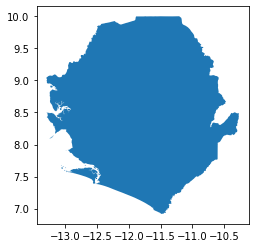

In [47]:
def add_gdp_data(
    df_gadm,
    year=2020,
    update=False,
    out_logging=False,
    name_file_nc="GDP_PPP_1990_2015_5arcmin_v2.nc",
    all_touched=False,
):
    """Function to add the population info for each country shape in the gadm dataset"""

    if out_logging:
        print("Add population data to GADM GeoDataFrame")

    # initialize new population column
    df_gadm["gdp"] = 0

    GDP_tif, name_tif = load_GDP(year, update, out_logging, name_file_nc)

    with rasterio.open(GDP_tif) as src:
        # data_GDP = src.read(1)
        # resample data to target shape

        for index, row in df_gadm.iterrows():
            # select the desired area of the raster corresponding to each polygon
            # Approximation: the gdp is measured including the pixels
            #   where the border of the shape lays. This has an averaging effect
            #   that may be noisy when shapes are too small
            out_image, out_transform = mask(
                src, row["geometry"], all_touched, invert=False, nodata=0.0
            )
            # out_image_int, out_transform = mask(src,
            #                                row["geometry"],
            #                                all_touched=False,
            #                                invert=False,
            #                                nodata=0.0)

            print(out_image)
            print((out_image > 0).any())

            # calculate total gdp in the selected geometry
            gdp_by_geom = np.nansum(out_image)
            print(gdp_by_geom)
            # gdp_by_geom = out_image.sum()/2 + out_image_int.sum()/2

            if out_logging == True:
                print("shape: ", index, " out of ", df_gadm.shape[0])

            # update the gdp data in the dataset
            df_gadm.loc[index, "gdp"] = gdp_by_geom
    return df_gadm


df_gadm2 = add_gdp_data(
    df_gadm,
    year=2020,
    update=False,
    out_logging=True,
    name_file_nc="GDP_PPP_1990_2015_5arcmin_v2.nc",
    all_touched=True,
)

print(df_gadm2.gdp.sum())

In [36]:
from shapely.geometry import Polygon

def add_gdp_data2(df_countries, df_gadm, year=2020, update=False, out_logging=False, name_file_nc="GDP_PPP_1990_2015_5arcmin_v2.nc", all_touched=False):
    """Function to add the population info for each country shape in the gadm dataset"""
    
    if out_logging:
        print("Add population data to GADM GeoDataFrame")

    # initialize new population column
    df_gadm["gdp"] = 0

    GDP_tif, name_tif = load_GDP(year, update, out_logging, name_file_nc)
    
    with rasterio.open(GDP_tif) as src:
        data_GDP = src.read(1)
        # resample data to target shape

        for x in range(src.width):
            for y in range(src.height):
                
            px, py = src.transform * (x, y)

            square_pixel = Polygon([(px, py), (px + src.res[0], px)])
                
        
        for index, row in df_gadm.iterrows():
            # select the desired area of the raster corresponding to each polygon
            # Approximation: the gdp is measured including the pixels
            #   where the border of the shape lays. This has an averaging effect
            #   that may be noisy when shapes are too small
            out_image, out_transform = mask(src,
                                            row["geometry"],
                                            all_touched,
                                            invert=False,
                                            nodata=0.0)
            # out_image_int, out_transform = mask(src,
            #                                row["geometry"],
            #                                all_touched=False,
            #                                invert=False,
            #                                nodata=0.0)

            print(out_image)
            print((out_image > 0).any())

            # calculate total gdp in the selected geometry
            gdp_by_geom = np.nansum(out_image)
            print(gdp_by_geom)
            # gdp_by_geom = out_image.sum()/2 + out_image_int.sum()/2
            
            if out_logging == True:
                print("shape: ", index, " out of ", df_gadm.shape[0])

            # update the gdp data in the dataset
            df_gadm.loc[index, "gdp"] = gdp_by_geom
    return df_gadm

df_gadm2  = add_gdp_data2(df_gadm, year=2020, update=False, out_logging=True, name_file_nc="GDP_PPP_1990_2015_5arcmin_v2.nc", all_touched=True)

print(df_gadm2.gdp.sum())